# analysis question: what is the error mode of interleaved group?
### the goal of this notebook is to explore a few possible hypotheses (ken email 04/18/21) about how people in the interleaved group are failing
- the strategy corresponding to our "new adjusted rand" measure (always giving one response for cafe and the other response for brew house)
- responding correctly
- always choosing the same state; trackable by looking at the absolute value of .5 - (proportion of "5" responses)... this is maximal if the proportion of "5" responses is 1 or 0; OR, you could do adjusted rand vs. an "all zero" reference (you should make sure this is maximal for "100% fives" and "100% sixes")
- always pressing the same button; trackable in much the same way as always choosing the same state (except you look at the button and not the state)
- random responding (trackable using something like entropy -- this may end up being inversely proportional to, and thus redundant with, measures of "always choosing the same state")


- win-stay lose-shift
- simple greedy RL agent that tracks how often 5 and 6 responses have been rewarded and chooses the one that has been rewarded more

In [1]:
CONDITION = 'interleaved_rep'
WINDOW = 20
TIMESTEP = 1
SAVING = True

In [2]:
import os, re
import pandas as pd
import numpy as np
import json

from sklearn.metrics import adjusted_rand_score

from glob import glob as glob


from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline
plt.rcParams['font.size'] = 22

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
from csw2022 import *

# load relevant dataframes
### need to pull out subjects response node to compare with schema

In [4]:
def load_df_with_state(condition,thresh=THRESHOLD):
  """ load dataframe and include information 
    about `tonode response` in dataframes 
  """
  ## load dataframe
  _df = load_final_df(condition,thresh)

  ## find right node and left node
  for i,d in _df.iterrows():
    # if true on right, right_node = true_tonode
    _df.loc[i,'right_state'] = node2stateD[
      [d.true_tonode,d.false_tonode][int(d.true_on_right)]
    ]
    _df.loc[i,'left_state'] = node2stateD[
      [d.true_tonode,d.false_tonode][np.abs(1-int(d.true_on_right))]
    ]
    # from_state and to_state
    _df.loc[i,'from_state'] = node2stateD[
      d.fromnode
    ]
    _df.loc[i,'to_state'] = node2stateD[
      d.true_tonode
    ]
    _df.loc[i,'to_state_false'] = node2stateD[
      d.false_tonode
    ]

  ## find response node
  for i,df_row in _df.iterrows():
    _df.loc[i,'response_state'] = [df_row.left_state,df_row.right_state][int(df_row.response_right)]
    _df.loc[i,'response_state_false'] = [df_row.right_state,df_row.left_state][int(df_row.response_right)]

  ## schema index
  _df.loc[:,'schema_idx'] = (_df.true_rfc.str.split('_').str[-1].str.split('-').str[1] == 'jungle').astype(int)

  return _df



In [5]:
# load dataframe
fulldf = df = load_df_with_state(CONDITION,thresh=THRESHOLD)

## subjects available after thresholding
df.index.get_level_values('subjnum').unique().values


-loading code version: RT01B1000cl
N = 55 subjects


array([ 1,  3,  5,  8,  9, 11, 12, 13, 16, 20, 21, 23, 24, 25, 27, 28, 29,
       30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48,
       49, 50, 51, 53, 54])

# TBD

In [6]:

def mov_avg(X,window=WINDOW):
  Y = -99*np.ones(len(X)-window)
  for ix in range(len(X)-window):
    Y[ix] = np.mean(X[ix:ix+window])
  return Y

def mov_avg_subdf(_sub_df):
  return mov_avg(_sub_df.correct_response.values)
  

def windowed_adjusted_rand(X,Y,window=WINDOW):
  assert len(X)==len(Y)
  AR = -99*np.ones(len(X)-window)
  for wi in range(len(X)-window):
    AR[wi] = adjusted_rand_score(
      X[wi:wi+window],
      Y[wi:wi+window]
    )
  return AR

def adjrand_response_vs_schema(_sub_df,window=WINDOW):
  ARmetric = windowed_adjusted_rand(
    X = _sub_df.response_state.values,
    Y = _sub_df.schema_idx.values,
    window=window
  )
  return ARmetric

def respond_same_node_adjrand_subdf(_sub_df,window=WINDOW):
  """ adjusted rand against constant sequence
  """
  ARmetric = windowed_adjusted_rand(
    X = _sub_df.response_state.values,
    Y = np.ones(len(_sub_df)),
    window=window
  )
  return ARmetric

def respond_same_node_counting_subdf(_sub_df,window=WINDOW):
  X = _sub_df.response_state.values
  R = -99*np.ones(len(X)-window)
  for ix in range(len(X)-window):
    R[ix] = np.sum(X[ix:ix+window]==5)/window
  return R

def windowed_entropy(X,window=WINDOW):
  binary_entropy_function = lambda p: -p*np.log2(p)-(1-p)*np.log2(1-p)
  R = -99*np.ones(len(X)-window)
  for ix in range(len(X)-window):
    p = np.mean(X[ix:ix+window]==X[0])
    R[ix] = binary_entropy_function(p)
  return R
    
def respond_randomly_subdf(_sub_df,window=WINDOW):
  R = windowed_entropy(
    _sub_df.response_state.values,
    window=window
  )
  return R

def respond_same_button_subdf(_sub_df,window=WINDOW):
  return mov_avg(_sub_df.response_right.values, window=WINDOW)

In [7]:
## helper funs to carve df
get_fromstate_df = lambda df,state_ix: df[df.from_state == state_ix]
get_tstep_df = lambda df,tstep: df[df.index.get_level_values('depth') == tstep]
get_schema_df = lambda df,sch_ix: df[df.schema_idx == sch_ix]

In [8]:
def winstay_looseshift_responses(_sub_df):
  """ 
  if correct, choose same to_state next time from_state is observed
  """
  strat_response = -np.ones(len(_sub_df))
  # relevant to_states are 5,6,7,8
  strat_response_map = np.concatenate([
    np.random.choice([5,6],2),
    np.random.choice([7,8],2)
  ])
  for ix,(_,row) in enumerate(_sub_df.iterrows()):
    strat_response[ix] = strat_response_map[int(row.from_state)-3]
    # relevant from_states are 3,4,5,6 
    strat_response_map[int(row.from_state)-3] = [
      row.response_state_false,row.response_state
    ][row.correct_response]

  return strat_response


In [9]:
## empty, to make sub_df_debug avail
for ix,(sidx,sub_df_debug) in enumerate(df.groupby('subjnum')):
  ix
# sub_df_debug


In [10]:
# assert False

# figure making

In [11]:
def plt_wrap(subdf_plt_fn):
  """ wrapper for plotting all subjects
  """
  fg,axar = plt.subplots(10,5,figsize=(40,40),sharey=True,sharex=True);axar=axar.reshape(-1)
  for ix,(sidx,sub_df) in enumerate(df.groupby('subjnum')):
    ax=axar[ix]
    subdf_plt_fn(sub_df,ax)
  axar[0].legend()
  axar[-1].twinx().set_ylabel('acc')

def subdf_plt_common_metric_against_acc(sub_df,ax,metric,pltkwargs,ylim=(0,1.02)):
  """ abstract fun
    instantiate by passing metric and pltkwargs
  """
  # fraction of same node responses in specified window
  metric_score = metric(sub_df)
  acc = mov_avg_subdf(sub_df)
  ## 
  ax.plot(metric_score,**pltkwargs)
  ax.set_ylim(*ylim)
  ax2=ax.twinx()
  ax2.plot(acc,label='acc',c='g')
  ax2.set_ylim(0,1.02)
  


### adjrand response vs schema

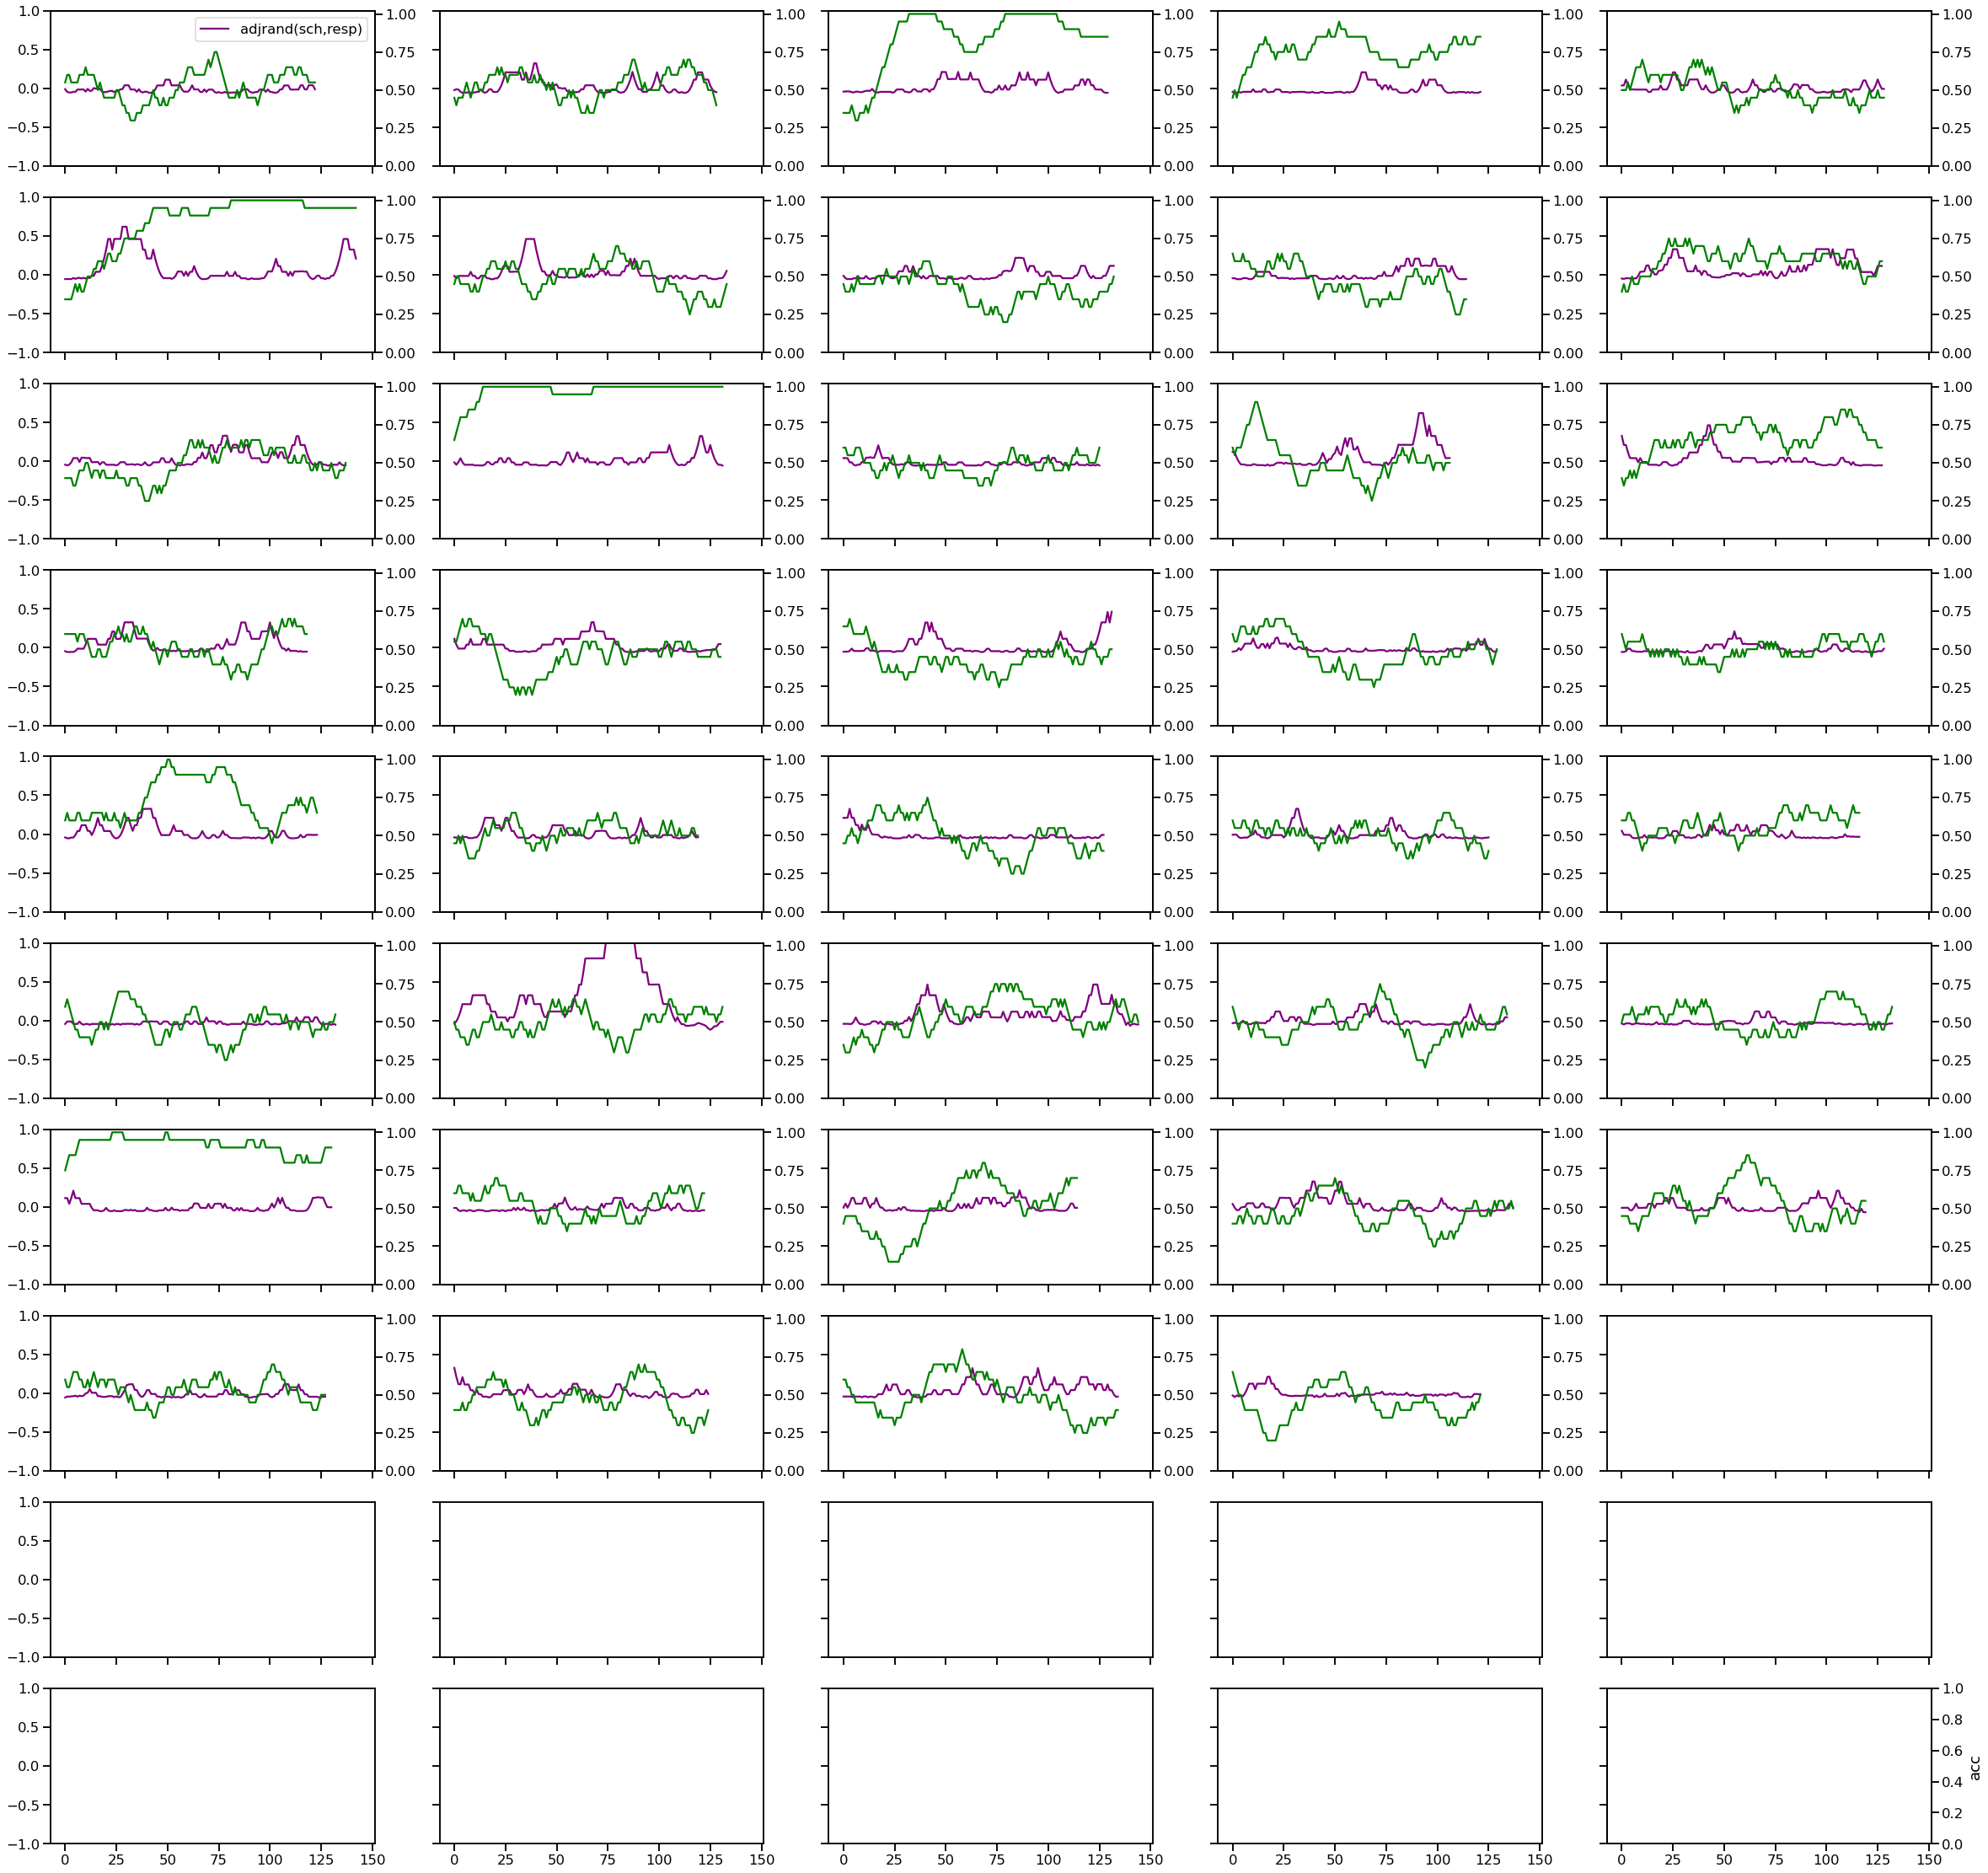

In [12]:
subdf_plt_adjrand_respsch = lambda sub_df,ax: \
  subdf_plt_common_metric_against_acc(
    get_tstep_df(sub_df,1),ax,
    metric=adjrand_response_vs_schema,
    pltkwargs={'color':'purple','label':'adjrand(sch,resp)'},
    ylim=(-1,1)
)
  
plt_wrap(subdf_plt_adjrand_respsch)
if SAVING:
  plt_name='adjrand_schresp'
  plt.savefig('figures/windowed_analyses/%s-%s'%(plt_name,CONDITION))

### same button

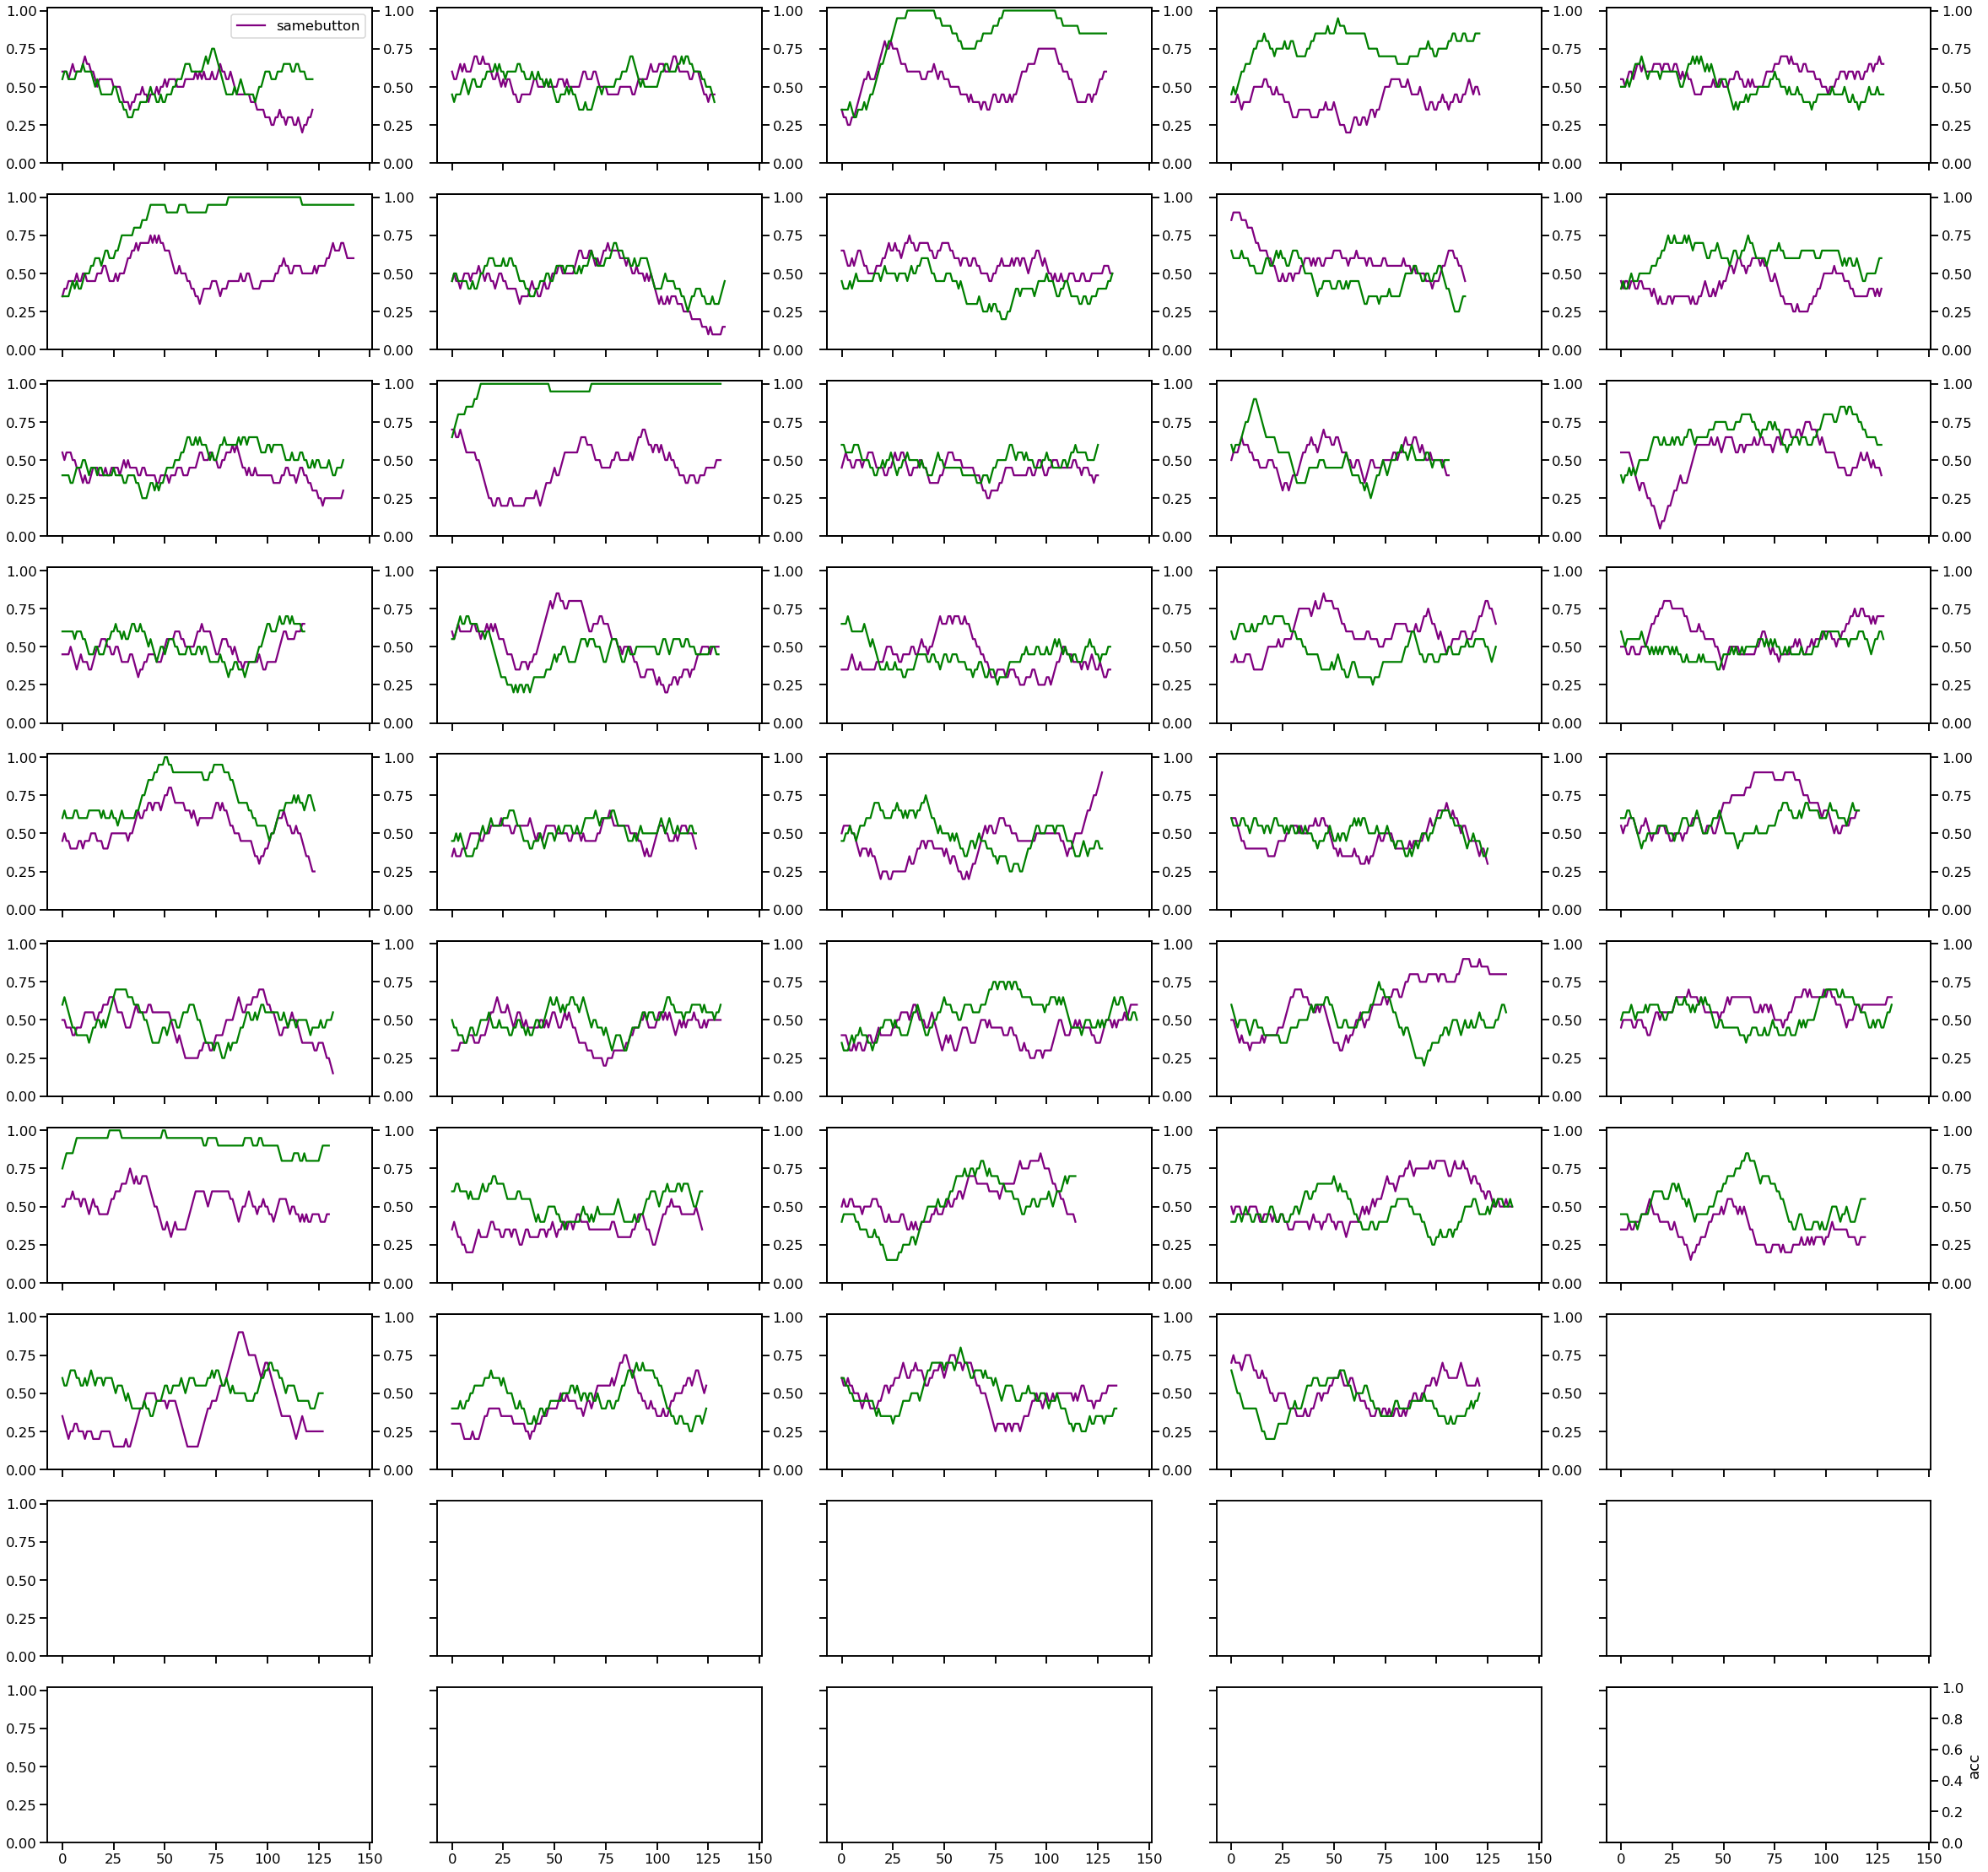

In [13]:
subdf_plt_samebutton = lambda sub_df,ax: \
  subdf_plt_common_metric_against_acc(
    get_tstep_df(sub_df,1),ax,
    metric=respond_same_button_subdf,
    pltkwargs={'color':'purple','label':'samebutton'}
)
  
plt_wrap(subdf_plt_samebutton)
if SAVING:
  plt_name='same_button'
  plt.savefig('figures/windowed_analyses/%s-%s'%(plt_name,CONDITION))

### same node

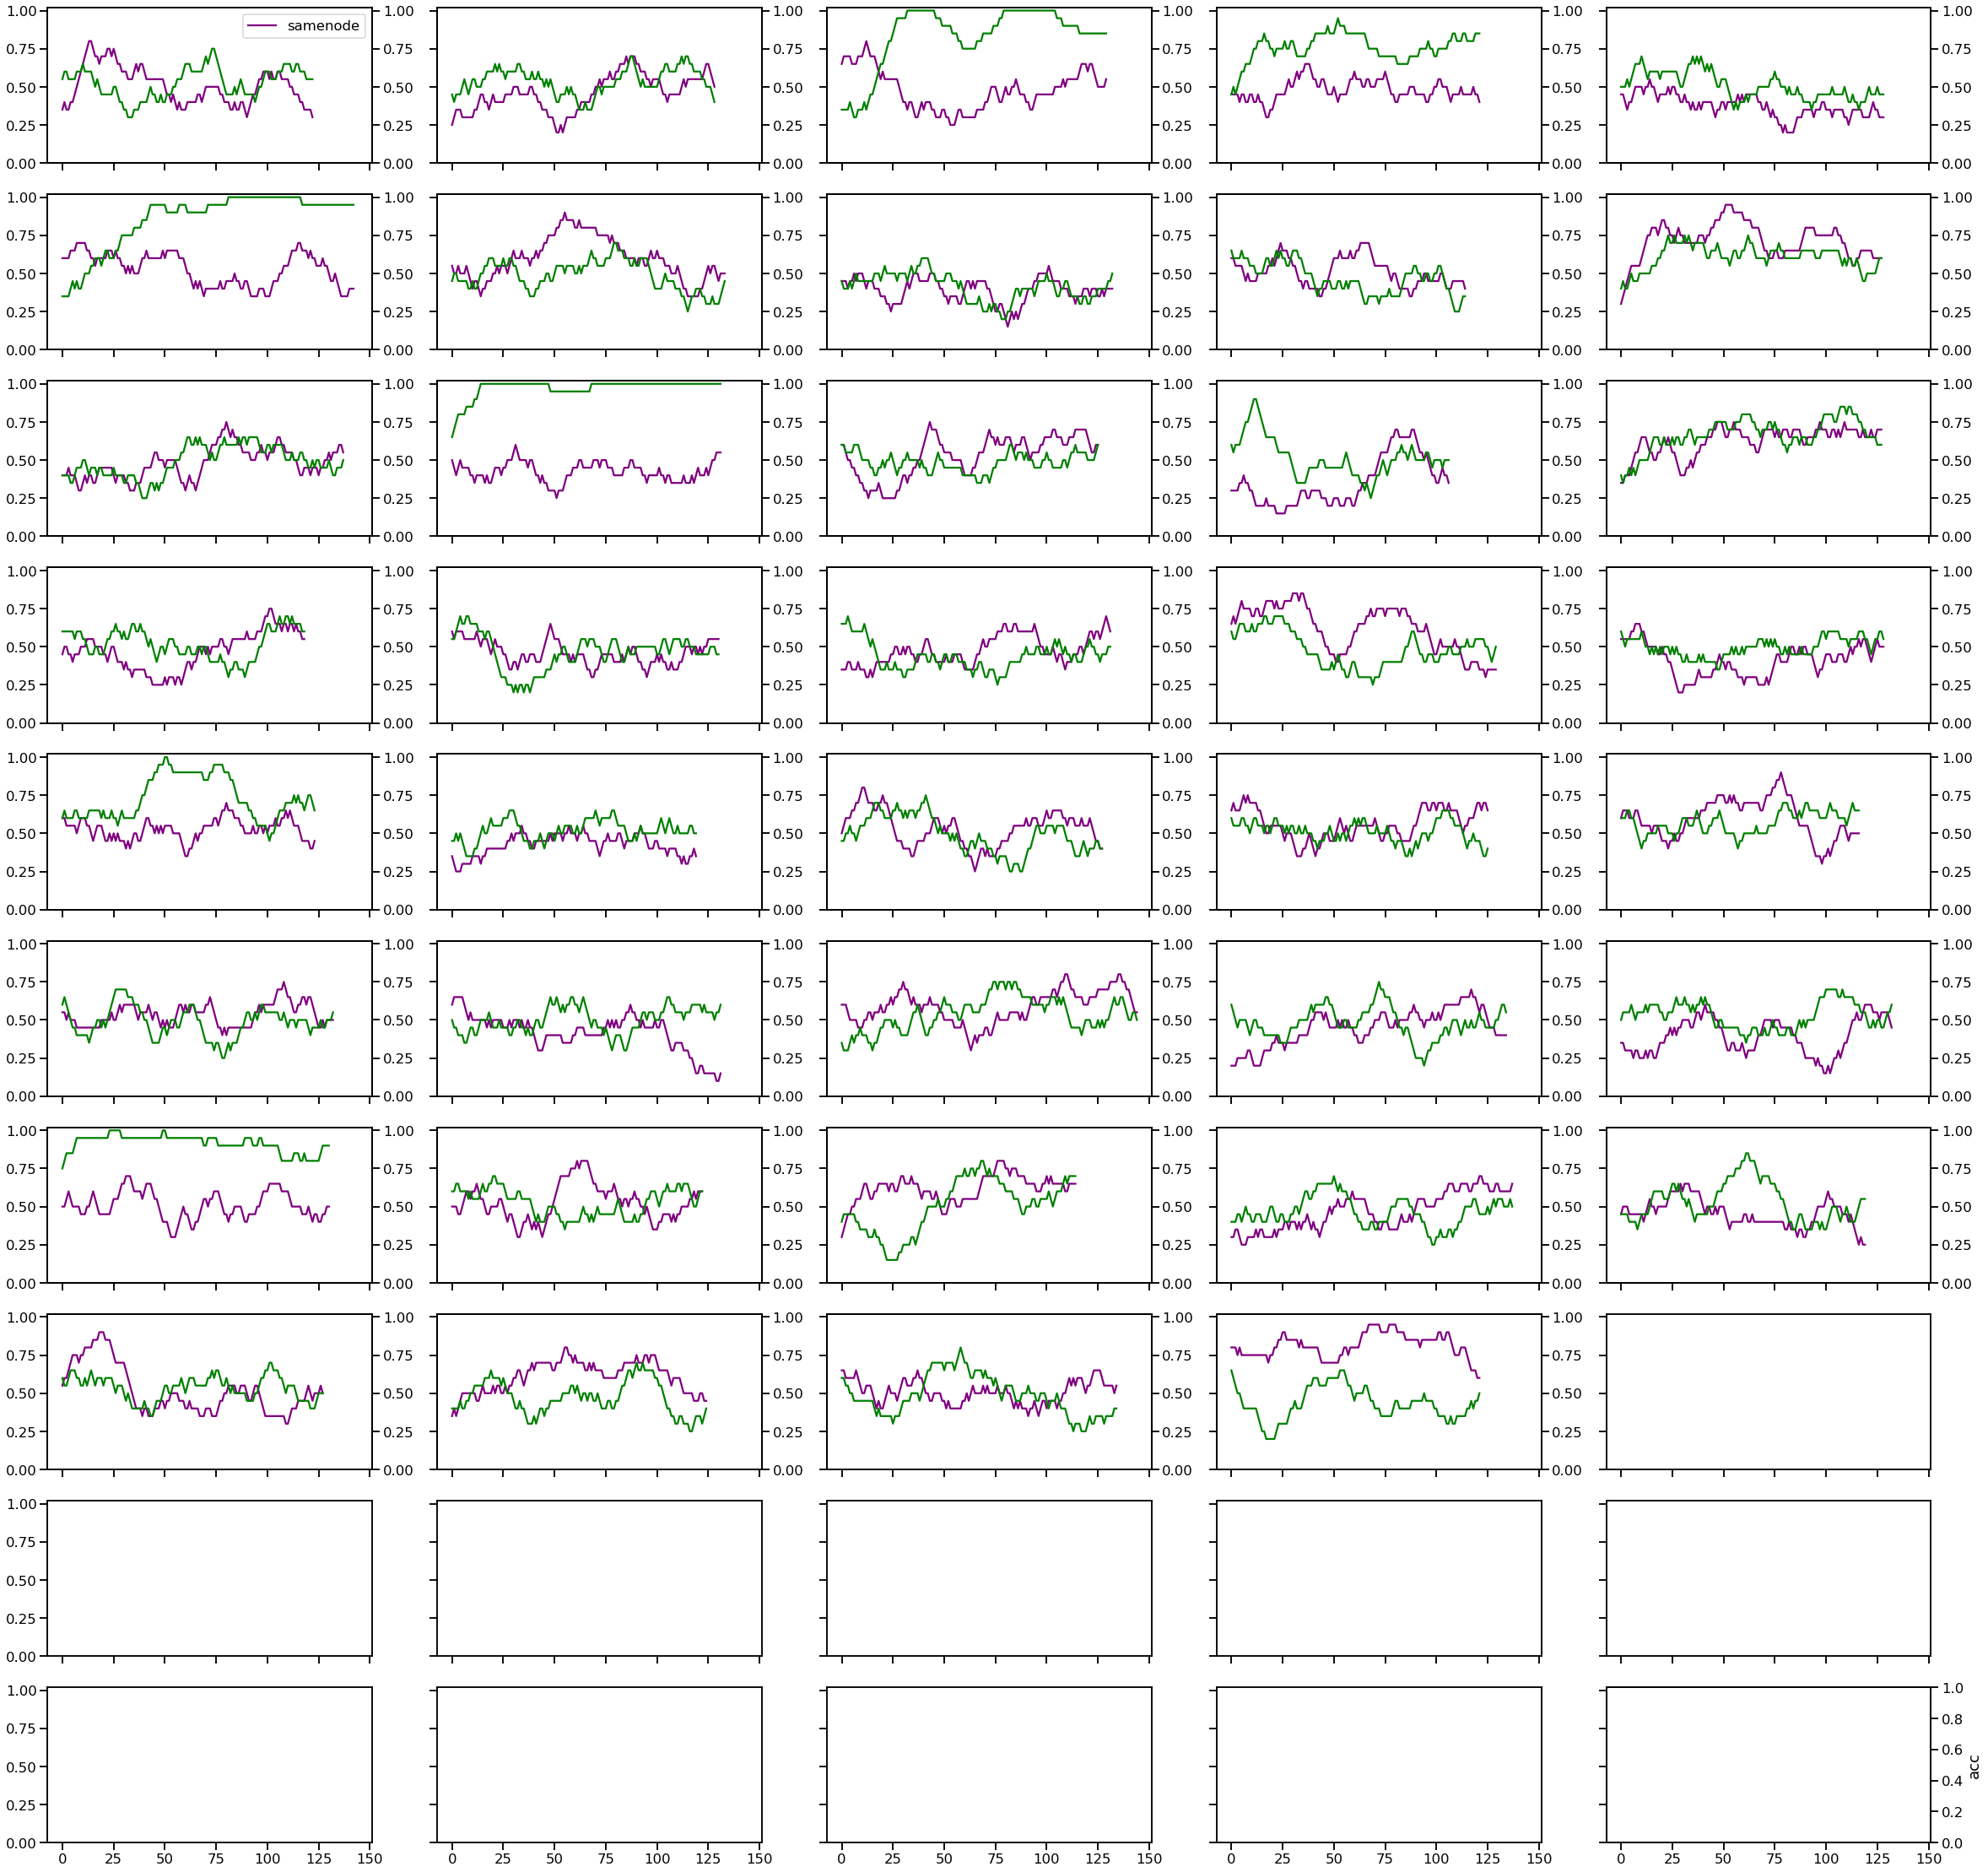

In [14]:
subdf_plt_samenode = lambda sub_df,ax: \
  subdf_plt_common_metric_against_acc(
    get_tstep_df(sub_df,1),ax,
    metric=respond_same_node_counting_subdf,
    pltkwargs={'color':'purple','label':'samenode'}
)
plt_wrap(subdf_plt_samenode)
if SAVING:
  plt_name='same_node'
  plt.savefig('figures/windowed_analyses/%s-%s'%(plt_name,CONDITION))

### winstay loose shift
* TODO: - winstay_looseshift metric computes windowed “accuracy” match against subject response

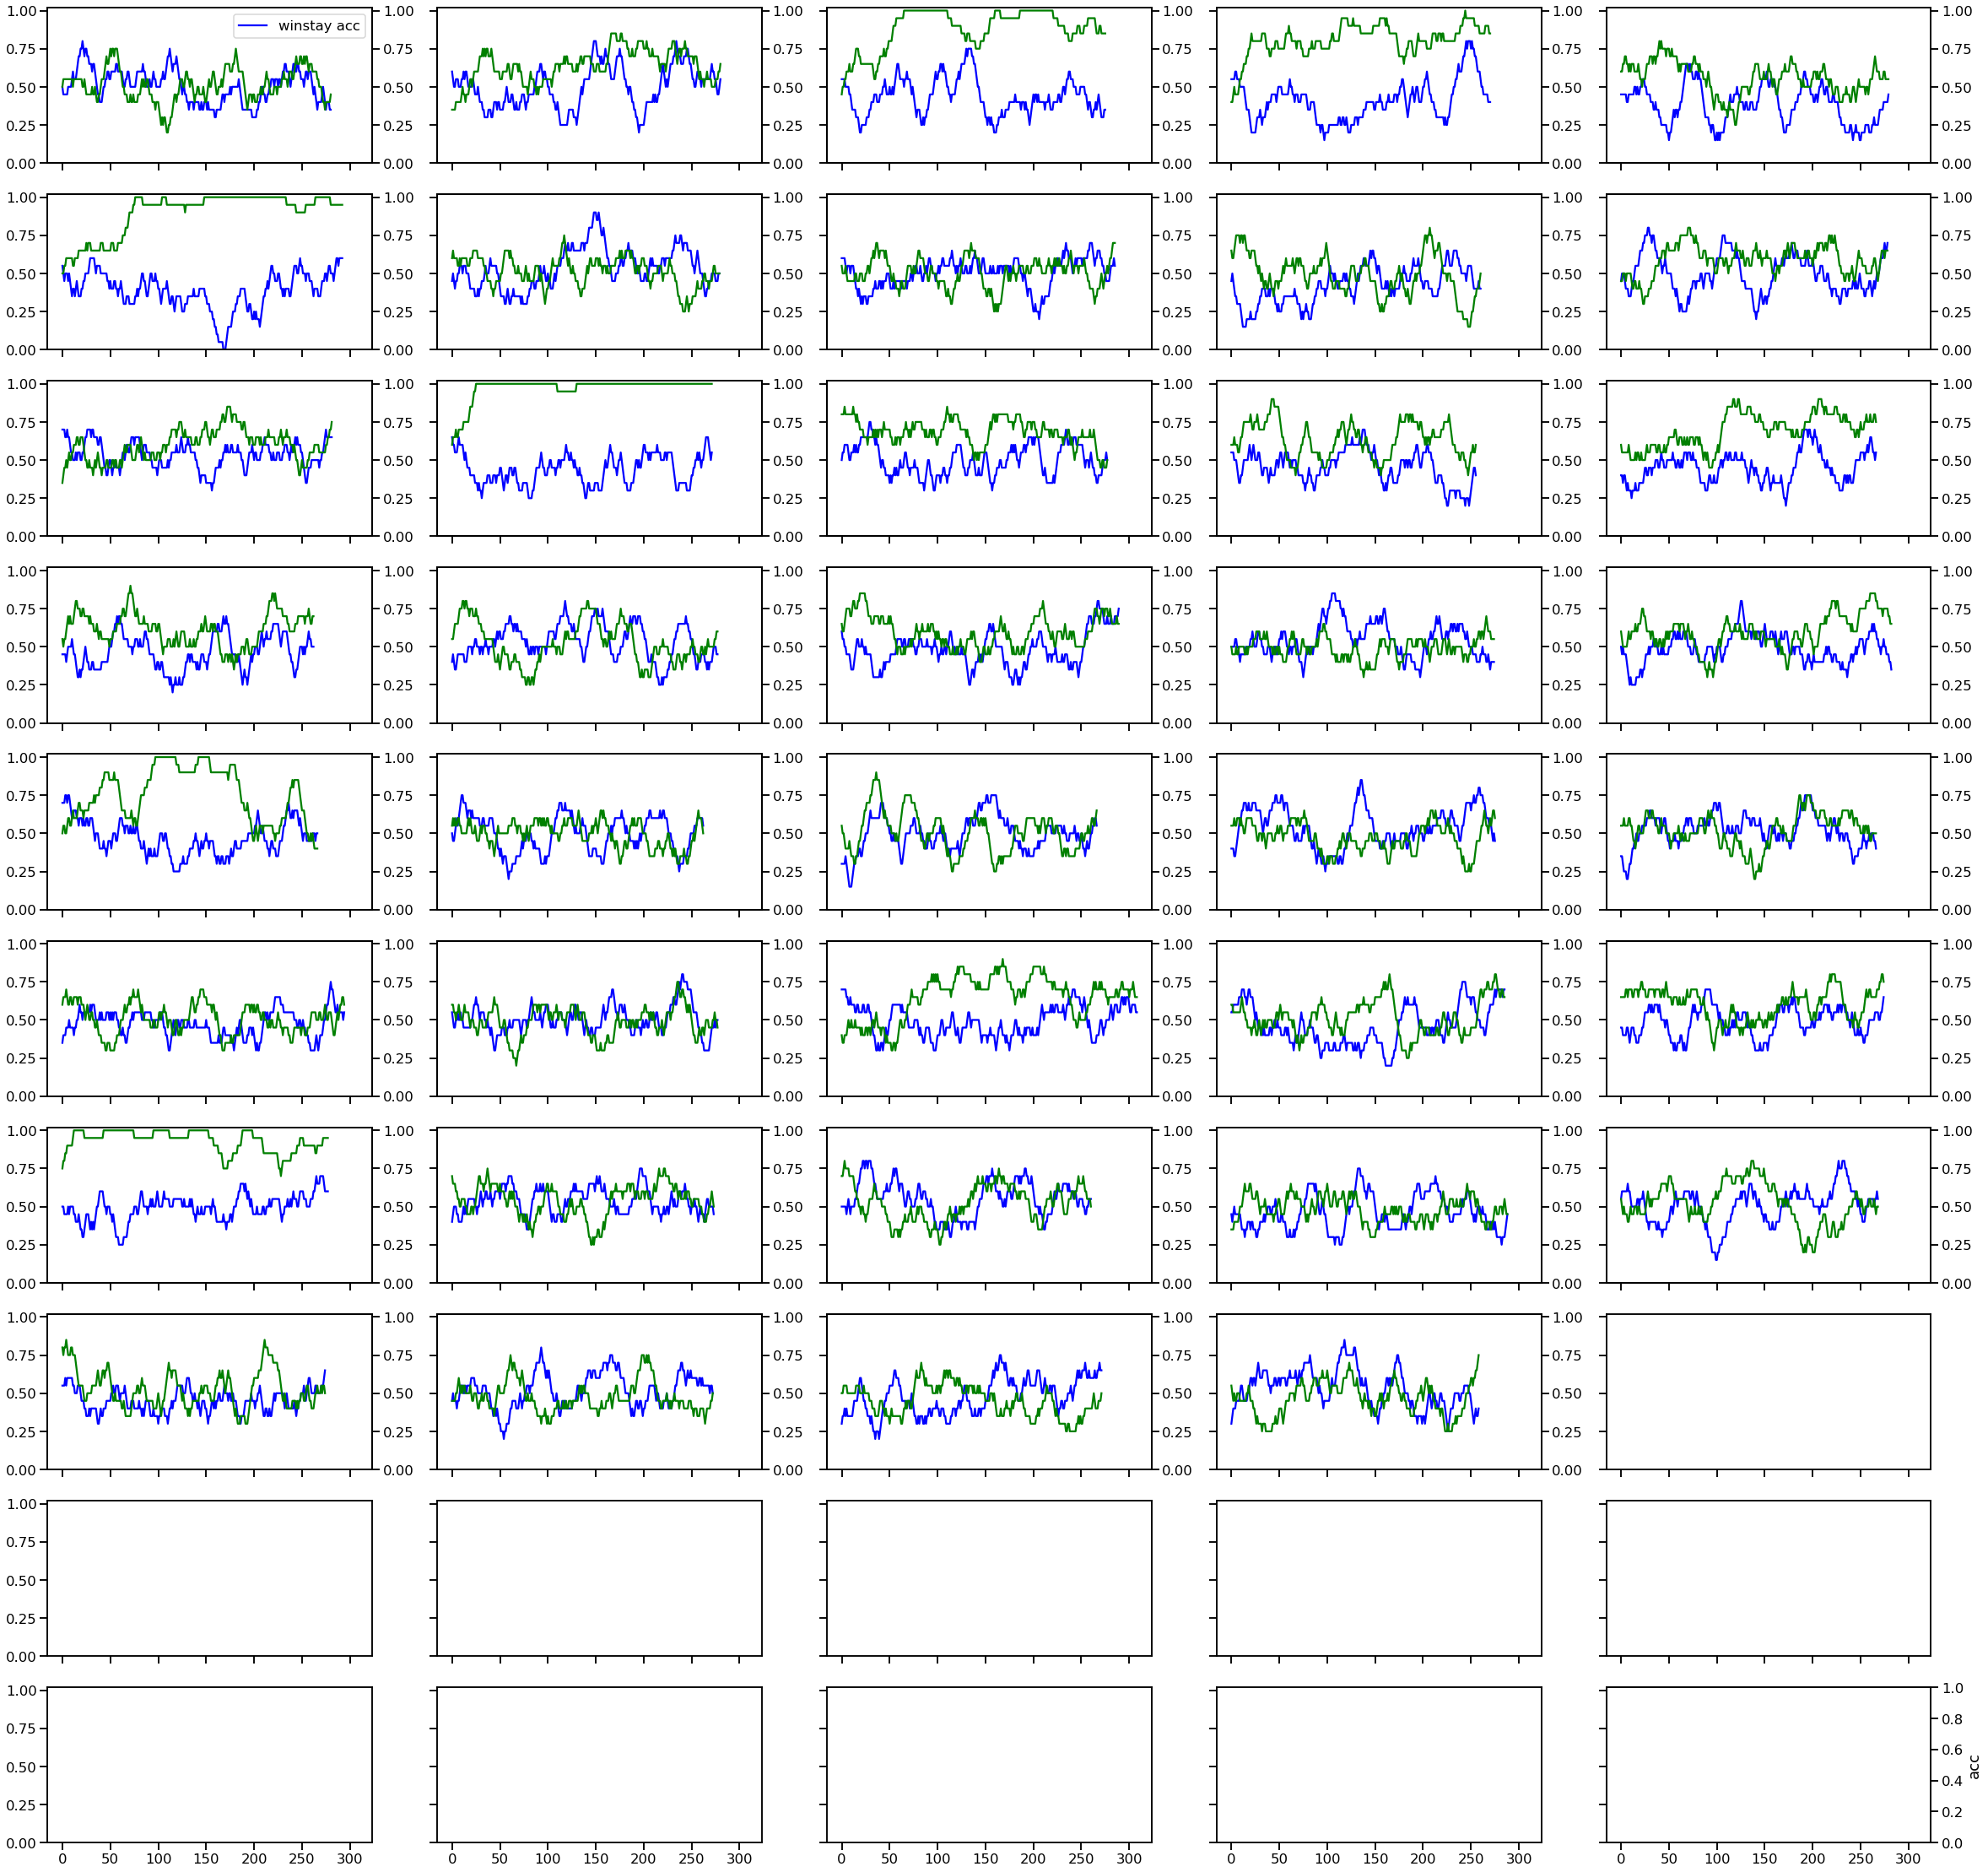

In [15]:
# def winstay_war(_sub_df):
#   winstay_strat_resp = winstay_looseshift_responses(_sub_df)
#   sub_resp = _sub_df.response_state.values
#   return windowed_adjusted_rand(sub_resp,winstay_strat_resp)

def winstay_acc(_sub_df):
  winstay_strat_resp = winstay_looseshift_responses(_sub_df)
  winstay_acc = mov_avg(np.array(
    winstay_strat_resp == _sub_df.response_state.values
  ).astype(int))  
  return winstay_acc

subdf_plt_samenode = lambda sub_df,ax: \
  subdf_plt_common_metric_against_acc(sub_df,ax,
    metric=winstay_acc,
    pltkwargs={'color':'blue','label':'winstay acc'}
)
plt_wrap(subdf_plt_samenode)
if SAVING:
  plt_name='winstay_acc'
  plt.savefig('figures/windowed_analyses/%s-%s'%(plt_name,CONDITION))

### entropy barplots
* breaking because cannot estimate entropy of very short string

In [16]:
# for ixx,_ in sub_df_debug.groupby(['depth','schema_idx','block','from_state']):
#   print(ixx,_.response_state.values.astype(int))

[5 6 6 6 6 5] [0.72192809]
[5 5 5 6 6 5 5] [0.91829583]
[5 6 6 6] [0.91829583]
[6 6 6] [nan]
[6 6 6] [nan]
[6 5 5 6 5 5] [0.97095059]
[5 5 6 6 5 6 5] [1.]
[5 5 5 6 6 6 5 5 5 5 5] [0.8812909]
[6 5 6 6 6 5 5 5 5 6 5 5] [0.99403021]
[5 6 6 6 5 6 6 6 6] [0.81127812]
[6 5 6 6 6 6 5 5 6] [0.954434]
[5 5 5 6 6 5 5 6 6] [0.954434]
[6 5 6 6 5 6 6 5 6] [0.954434]
[5 6 5 6 6 6 6 6 5] [0.81127812]
[5 5 5 5 5 6 6 6] [0.86312057]
[6 6 5 6 5] [0.81127812]
[5 5 5 6 5 5 5] [0.65002242]
[6 6 6 6 5] [nan]
[5 6 6 5 5 5] [0.97095059]
[6 6 5 6 6 5 6 6] [0.86312057]
[8 8 8 8 8 8 8 7 7] [0.54356444]
[8 8 7 8 7 8 8 7 7 7] [0.99107606]
[7 8 7 8 7] [1.]
[8 7 8 8 7 7] [0.97095059]
[7 8 7 8] [0.91829583]
[8 8 8 7 7 7 8 7] [0.98522814]
[7 7 8 7 7 7 8] [0.65002242]
[8 7 7 7 8 8 8 8 7 8 7] [0.97095059]
[7 8 7 8 8 8 8 7 7 8] [0.99107606]
[7 7 8 7 8 7 7 8 8 8 8] [1.]
[8 8 8 8 8 7 8] [0.65002242]
[7 8 7 8 8 7 8 8 8] [0.954434]
[8 8 7 8 7 8] [0.97095059]
[7 7 7 8 8] [0.81127812]
[8 7 7 8 7 8] [0.97095059]
[8 7 7 8 8 7 7 

<ipython-input-6-a39eb4de7867>:47: RuntimeWarning: divide by zero encountered in log2
  binary_entropy_function = lambda p: -p*np.log2(p)-(1-p)*np.log2(1-p)
<ipython-input-6-a39eb4de7867>:47: RuntimeWarning: invalid value encountered in double_scalars
  binary_entropy_function = lambda p: -p*np.log2(p)-(1-p)*np.log2(1-p)


 [nan]
[7 7 7 7 7 7 7 8 7 8 8] [0.72192809]
[6 6 6 6] [nan]
[6 6 6 6 5 6 6 6 6 5 5 6 5] [0.81127812]
[6 6 6 5 5 5 6] [1.]
[6 6 6 6 5 6 5] [0.65002242]
[6 6 5 6 6] [0.81127812]
[5 5 6 5 6 5 5 5] [0.86312057]
[6] [nan]
[5 6 6 6 5 6 6 6] [0.86312057]
[6 6 6 6 6 6 5 5] [0.59167278]
[6 6 6 6 5 6 6 6 6 6 6] [0.46899559]
[5 6 6 6 6 6 6] [0.65002242]
[6 6 6 6 6 5 5 5] [0.86312057]
[6 6 6 5 6 6 6] [0.65002242]
[6 6 6 5 5 6 5 6] [0.98522814]
[6 6 5 5 6 6 6 5 5 5 5] [1.]
[5 6 5 5 5 5 6 6 5] [0.954434]
[5 5 6 5 5 6] [0.72192809]
[6 6 5 5 5 6 6 5 5 5] [0.99107606]
[6 5 5 5 6 5] [0.97095059]
[5 5 6 6 5 5 6 6 6] [1.]
[8 8 8 8] [nan]
[8 8 7 7 8 8 8 8 7 7 7] [0.97095059]
[7 8 8 7 8 7 7 8] [0.98522814]
[7 7 8 8 8 7 8 7] [0.98522814]
[8 7 8 7] [0.91829583]
[7 8 8 7 7 7 7 7 7 7] [0.76420451]
[7 8 7] [1.]
[8 7 8 7 7 8 7 8] [0.98522814]
[8 7 8 7 7 7 7] [0.91829583]
[7 7 8 7 7 7 7 7 8 8 7] [0.8812909]
[8 7 8 8 8 7 7] [0.91829583]
[7 8 7 8 7 8 7] [1.]
[8 8 8 7 8 7 7 7 7 7] [0.99107606]
[8 7 7 7 7 8 7] [0.9182

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[6 6 6 6 6 6 6 6] [nan]
[6 6 6 6 6 6 6 6 5] [nan]
[6 6 6 6 6 6] [nan]
[6 6 6 6 5 6 6 5 6] [0.81127812]
[6 6 6 5 6 5 6 6 6] [0.81127812]
[6 5 5 5 5] [0.81127812]
[5 5 5 5 6 6 5 5] [0.86312057]
[5 5 5 5 5 5 5 5] [nan]
[5 5 5 5 5 5 5 5] [nan]
[5 5 6 5 5 5 5 5] [0.59167278]
[6 6 6 6 6 6 5] [nan]
[6 5 6 6 6 5 5 5 5 5 5] [0.97095059]
[5 5 6 5 5 5 6 6 5] [0.954434]
[5 6 5 5 5 5 5 6] [0.59167278]
[5 5 6 6 5 5] [0.97095059]
[5 5 5 5 5 5 5 5 5] [nan]
[5 5 5 5 5] [nan]
[6 5 5 5 5] [0.81127812]
[5 5 5 5 5 6] [nan]
[5 5 5 5] [nan]
[8 8 8 8 8 8 8] [nan]
[8 8 8 8 8 8 7 7 8] [0.81127812]
[8 8 8 8 8] [nan]
[8 8 8 8 8 8 8 8] [nan]
[8 8 8 8 8 8 8 8] [nan]
[7 8 7 7 8 8] [0.97095059]
[8 7 7 7 8 8 7] [1.]
[7 8 7 7 8 8] [0.97095059]
[7 8 7 7 7] [0.81127812]
[7 8 7 7 8] [0.81127812]
[7 7 7 8 7 8] [0.72192809]
[7 7 8 7 7 7] [0.72192809]
[7 7 7 7 7 7 7 7] [nan]
[7 7 7 7 7 8 7 7] [0.59167278]
[7 7 7 7 7 7 7 8] [nan]
[7 7 8 8 7 8] [0.97095059]
[7 7 7 7 8 7 7 7 7] [0.54356444]
[7 8 8 8 8 8 8 7] [0.59167278]
[7 8 8

[7 7 7 8 8 8 7] [1.]
[8 7 7 8 7] [1.]
[7 8 7] [1.]
[8 7 8 8 7 8 8] [0.91829583]
[8 7 7 7 7 8 7 8] [0.86312057]
[8 7 8 8 7 7 8 7 8] [1.]
[8 7 8 7 7 8 7 7 8 7 7] [0.97095059]
[7 7 7 7 7 8 8 7 7 8 8] [0.8812909]
[8 8 8 7 8 8 7 8 7] [0.81127812]
[7 7 8 7 7 8] [0.72192809]
[7 8 8 7 7 8 8 8 7] [0.954434]
[7 7 7 8 8 7 7 7 8] [0.81127812]
[7 7 8 8 8 7 8 8 8 7 7 8] [0.99403021]
[7 7 8 8 7 7 8 7] [0.98522814]
[7 7 8 7 7 8 7 7 8 8 7 7] [0.9456603]
[8 7 8 7 7 8] [0.97095059]
[8 7 8 8 7 8 8 7] [0.86312057]
[7 8 8 7 7 7] [0.97095059]
[8 8 7 8 7 8 8 8] [0.86312057]
[6 6 5 5 6 5 5 5 5] [0.954434]
[6 5 5 5 5 6 6] [0.91829583]
[5 6 5 5 5 5 5] [0.65002242]
[5 5 5 5 5 6 6 5 5 6] [0.76420451]
[5 6 6 5 6 6 6 6 5 6 6] [0.8812909]
[5 6 5 5 5 5 6 5 6 6 5] [0.97095059]
[5 5 6 5 5 5 6 6] [0.86312057]
[6 5 5 5 5 5 5 5 5] [0.54356444]
[5 5 5 5 6 5] [0.72192809]
[6 6 6 5 6 6] [0.72192809]
[5 5 6 6 6 6] [0.97095059]
[6 5 6 6 6 6 6] [0.65002242]
[6 6 6 6 6 6 6 6 6] [nan]
[6 6 6 6 6] [nan]
[5 6 6 6 6 5 6] [0.91829583]

No handles with labels found to put in legend.


 [0.59167278]
[5 5 5 5 6 5 5 5 5] [0.54356444]
[5 5 5 6 6 5 5 6] [0.86312057]
[7 7 8 8 7 7 8 8] [0.98522814]
[7 7 8] [nan]
[8 8 7 7 8 7] [0.97095059]
[7 7 7 7 7 8 7 7] [0.59167278]
[7 7 7 7 7 7 7 7 8 8 7 8] [0.68403844]
[7 8 7 7 8 8] [0.97095059]
[8 8 7 7 7 8 7 7] [0.98522814]
[8 7 8 7 7 7 7 8] [0.86312057]
[7 7 7 7 8 8 7 8] [0.86312057]
[7 8 8 7 7 7] [0.97095059]
[8 8] [nan]
[8 8 7 7 7 7 7 8 7 8 8] [0.97095059]
[8 7 7 8 7 7 7] [0.91829583]
[7 7 7 7 8 7 7 7 7 7] [0.50325833]
[7 7 7 7 7 7] [nan]
[7 8 7 8 7 7 7 8] [0.86312057]
[7 7 8 7 7] [0.81127812]
[8 7 7 8 7 7 7] [0.91829583]
[7 8 7 8] [0.91829583]
[7 7 7 8] [nan]


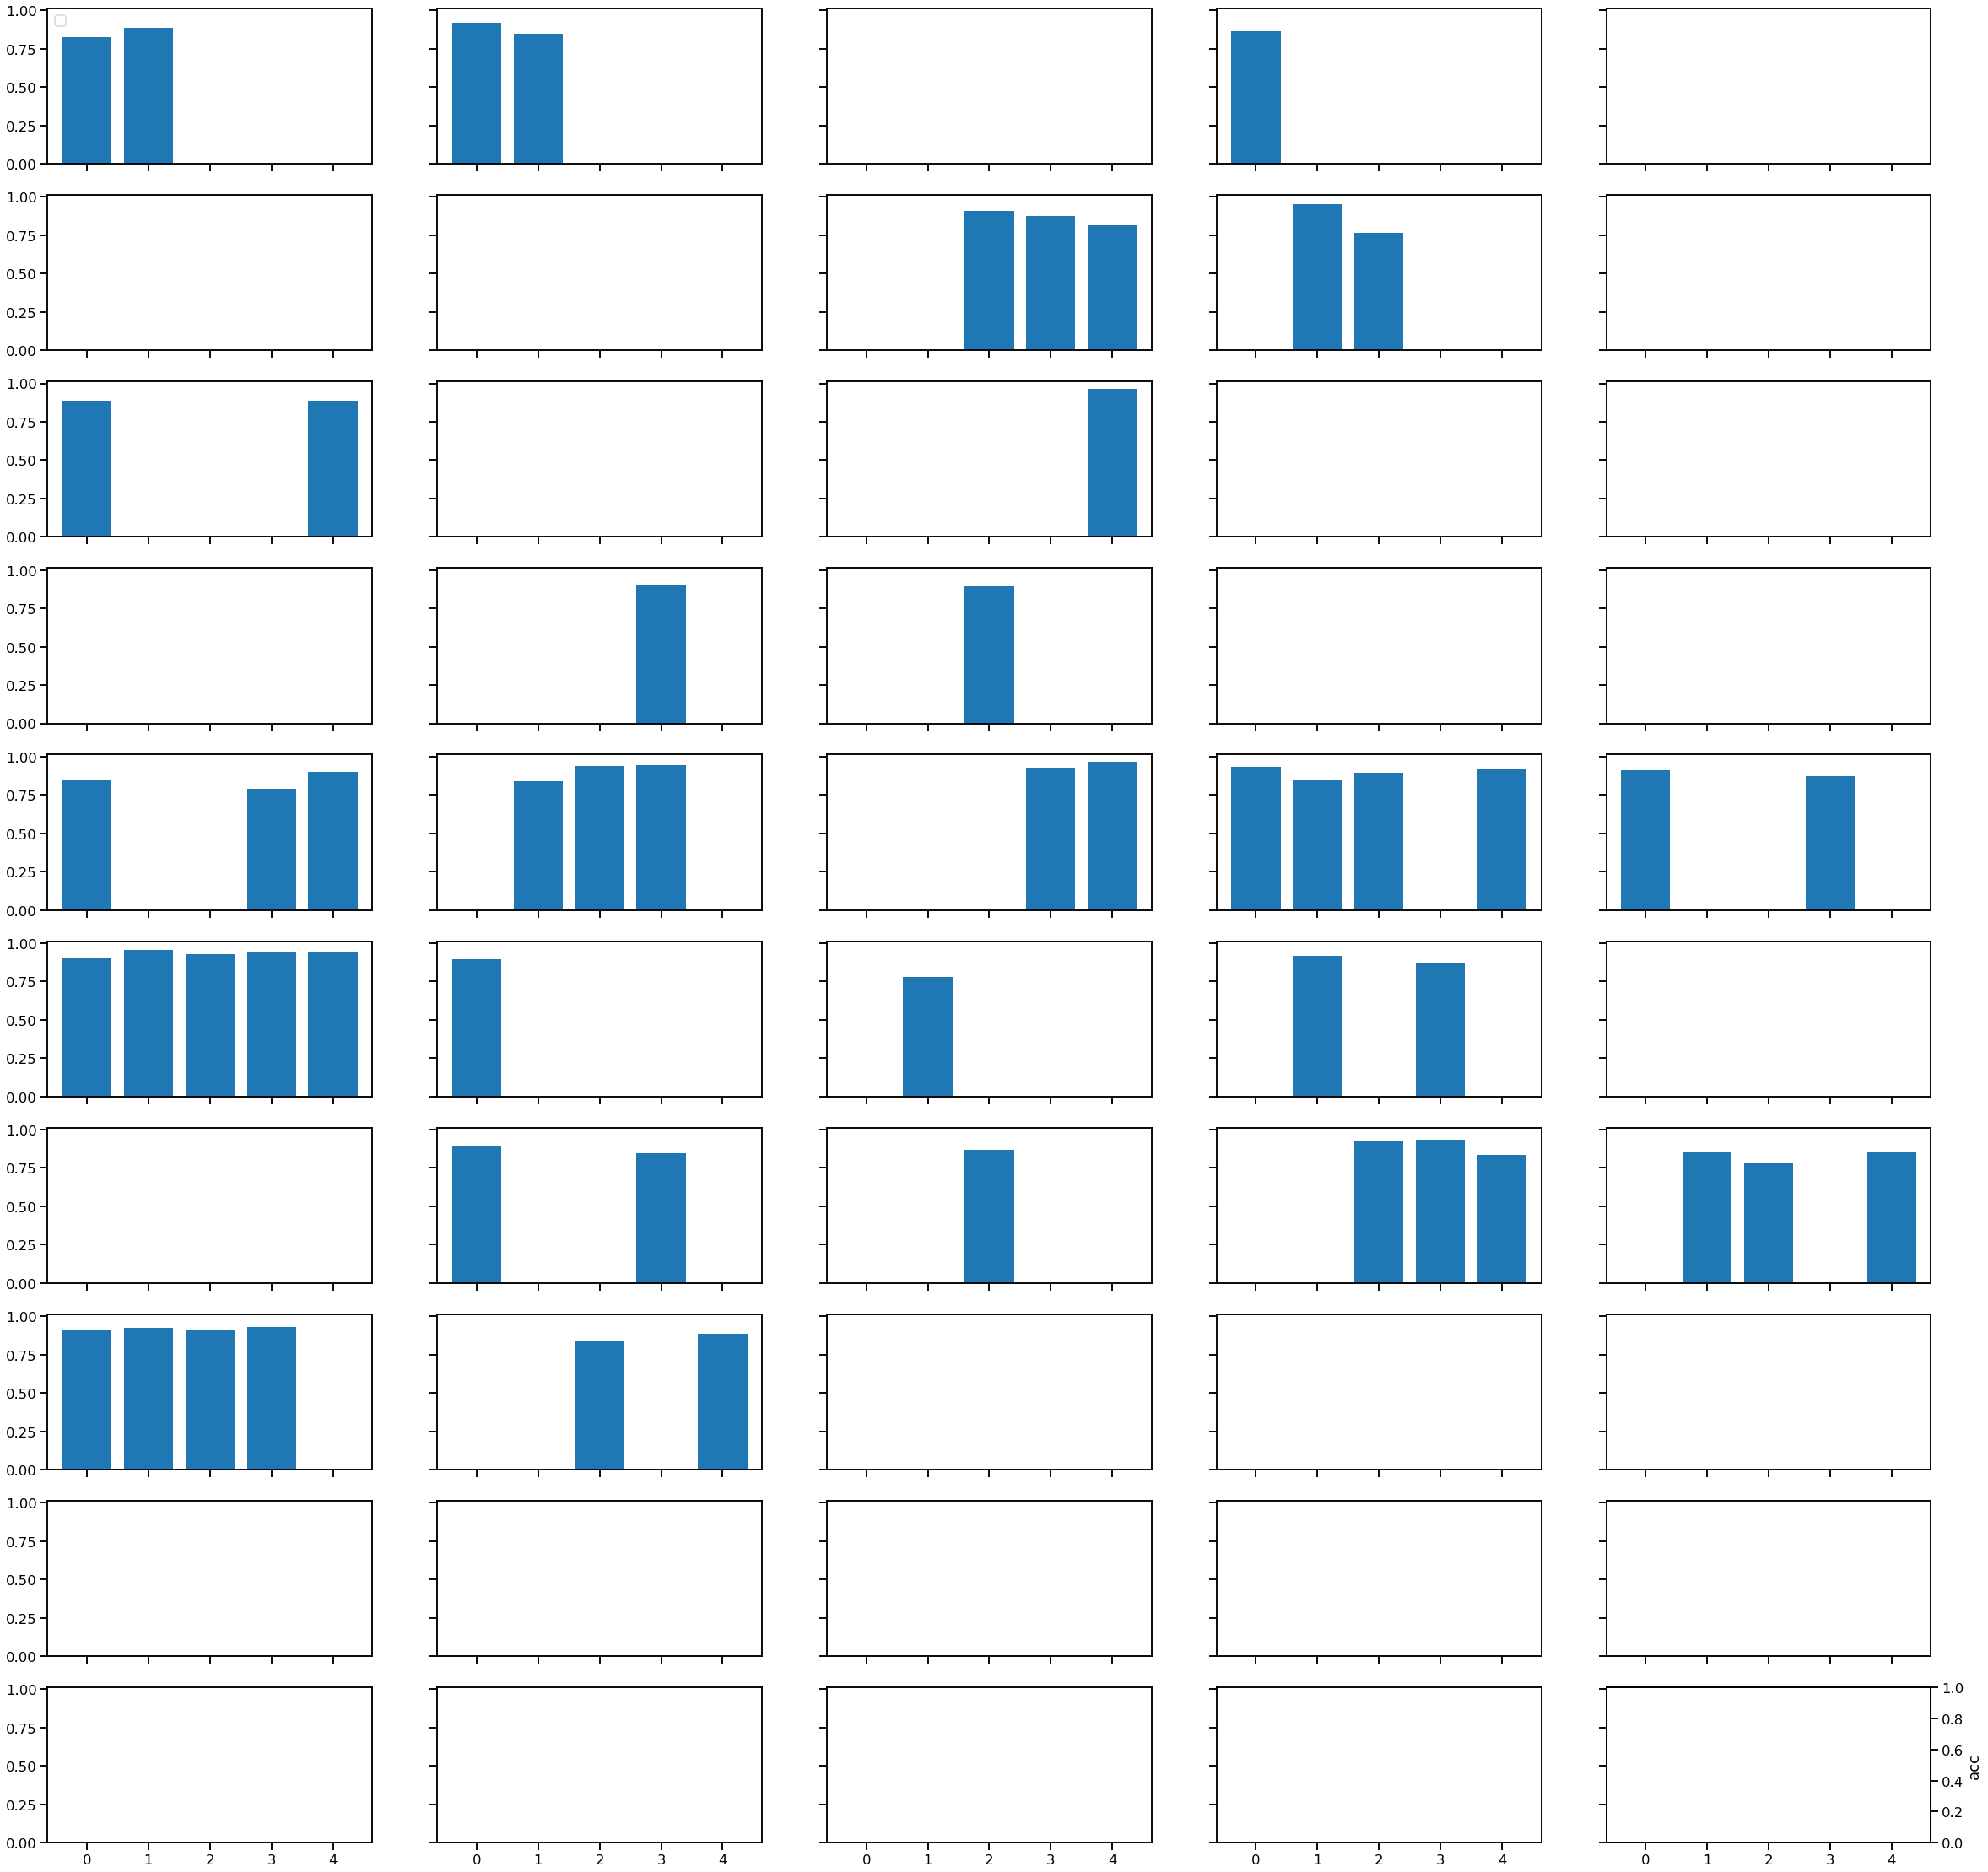

In [17]:
def subdf_plt_metric_by_block(_sub_df,ax):
  metric_score = response_entropy_per_block(_sub_df)
  ax.bar(range(len(metric_score)),metric_score)
  
def response_entropy_per_block(_sub_df):
  ent = -99*np.ones([2,2,2,5])# depth,schema,fromstate,block
  for multi_idx,subsub_df in _sub_df.groupby(['depth','schema_idx','from_state','block']):
    depth_idx,sch_idx,frst_idx,bl_idx = multi_idx
    resp = subsub_df.response_state.values.astype(int)
    print(resp,windowed_entropy(resp,len(resp)-1))
    if depth_idx==1:
      if frst_idx == 3.0: 
        fr_idx=0
      elif frst_idx == 4.0: 
        fr_idx=1
    elif depth_idx==2:
      if frst_idx == 5.0: 
        fr_idx=0
      elif frst_idx == 6.0: 
        fr_idx=1
    ent[depth_idx-1,sch_idx,fr_idx,bl_idx] = windowed_entropy(resp,len(resp)-1)
  ent_per_block = ent.mean((0,1,2))
  return ent_per_block

# subdf_plt_metric_by_block(sub_df_debug,plt.gca(),response_entropy_per_block)
plt_wrap(subdf_plt_metric_by_block)

# all together

NameError: name 'winstay_war' is not defined

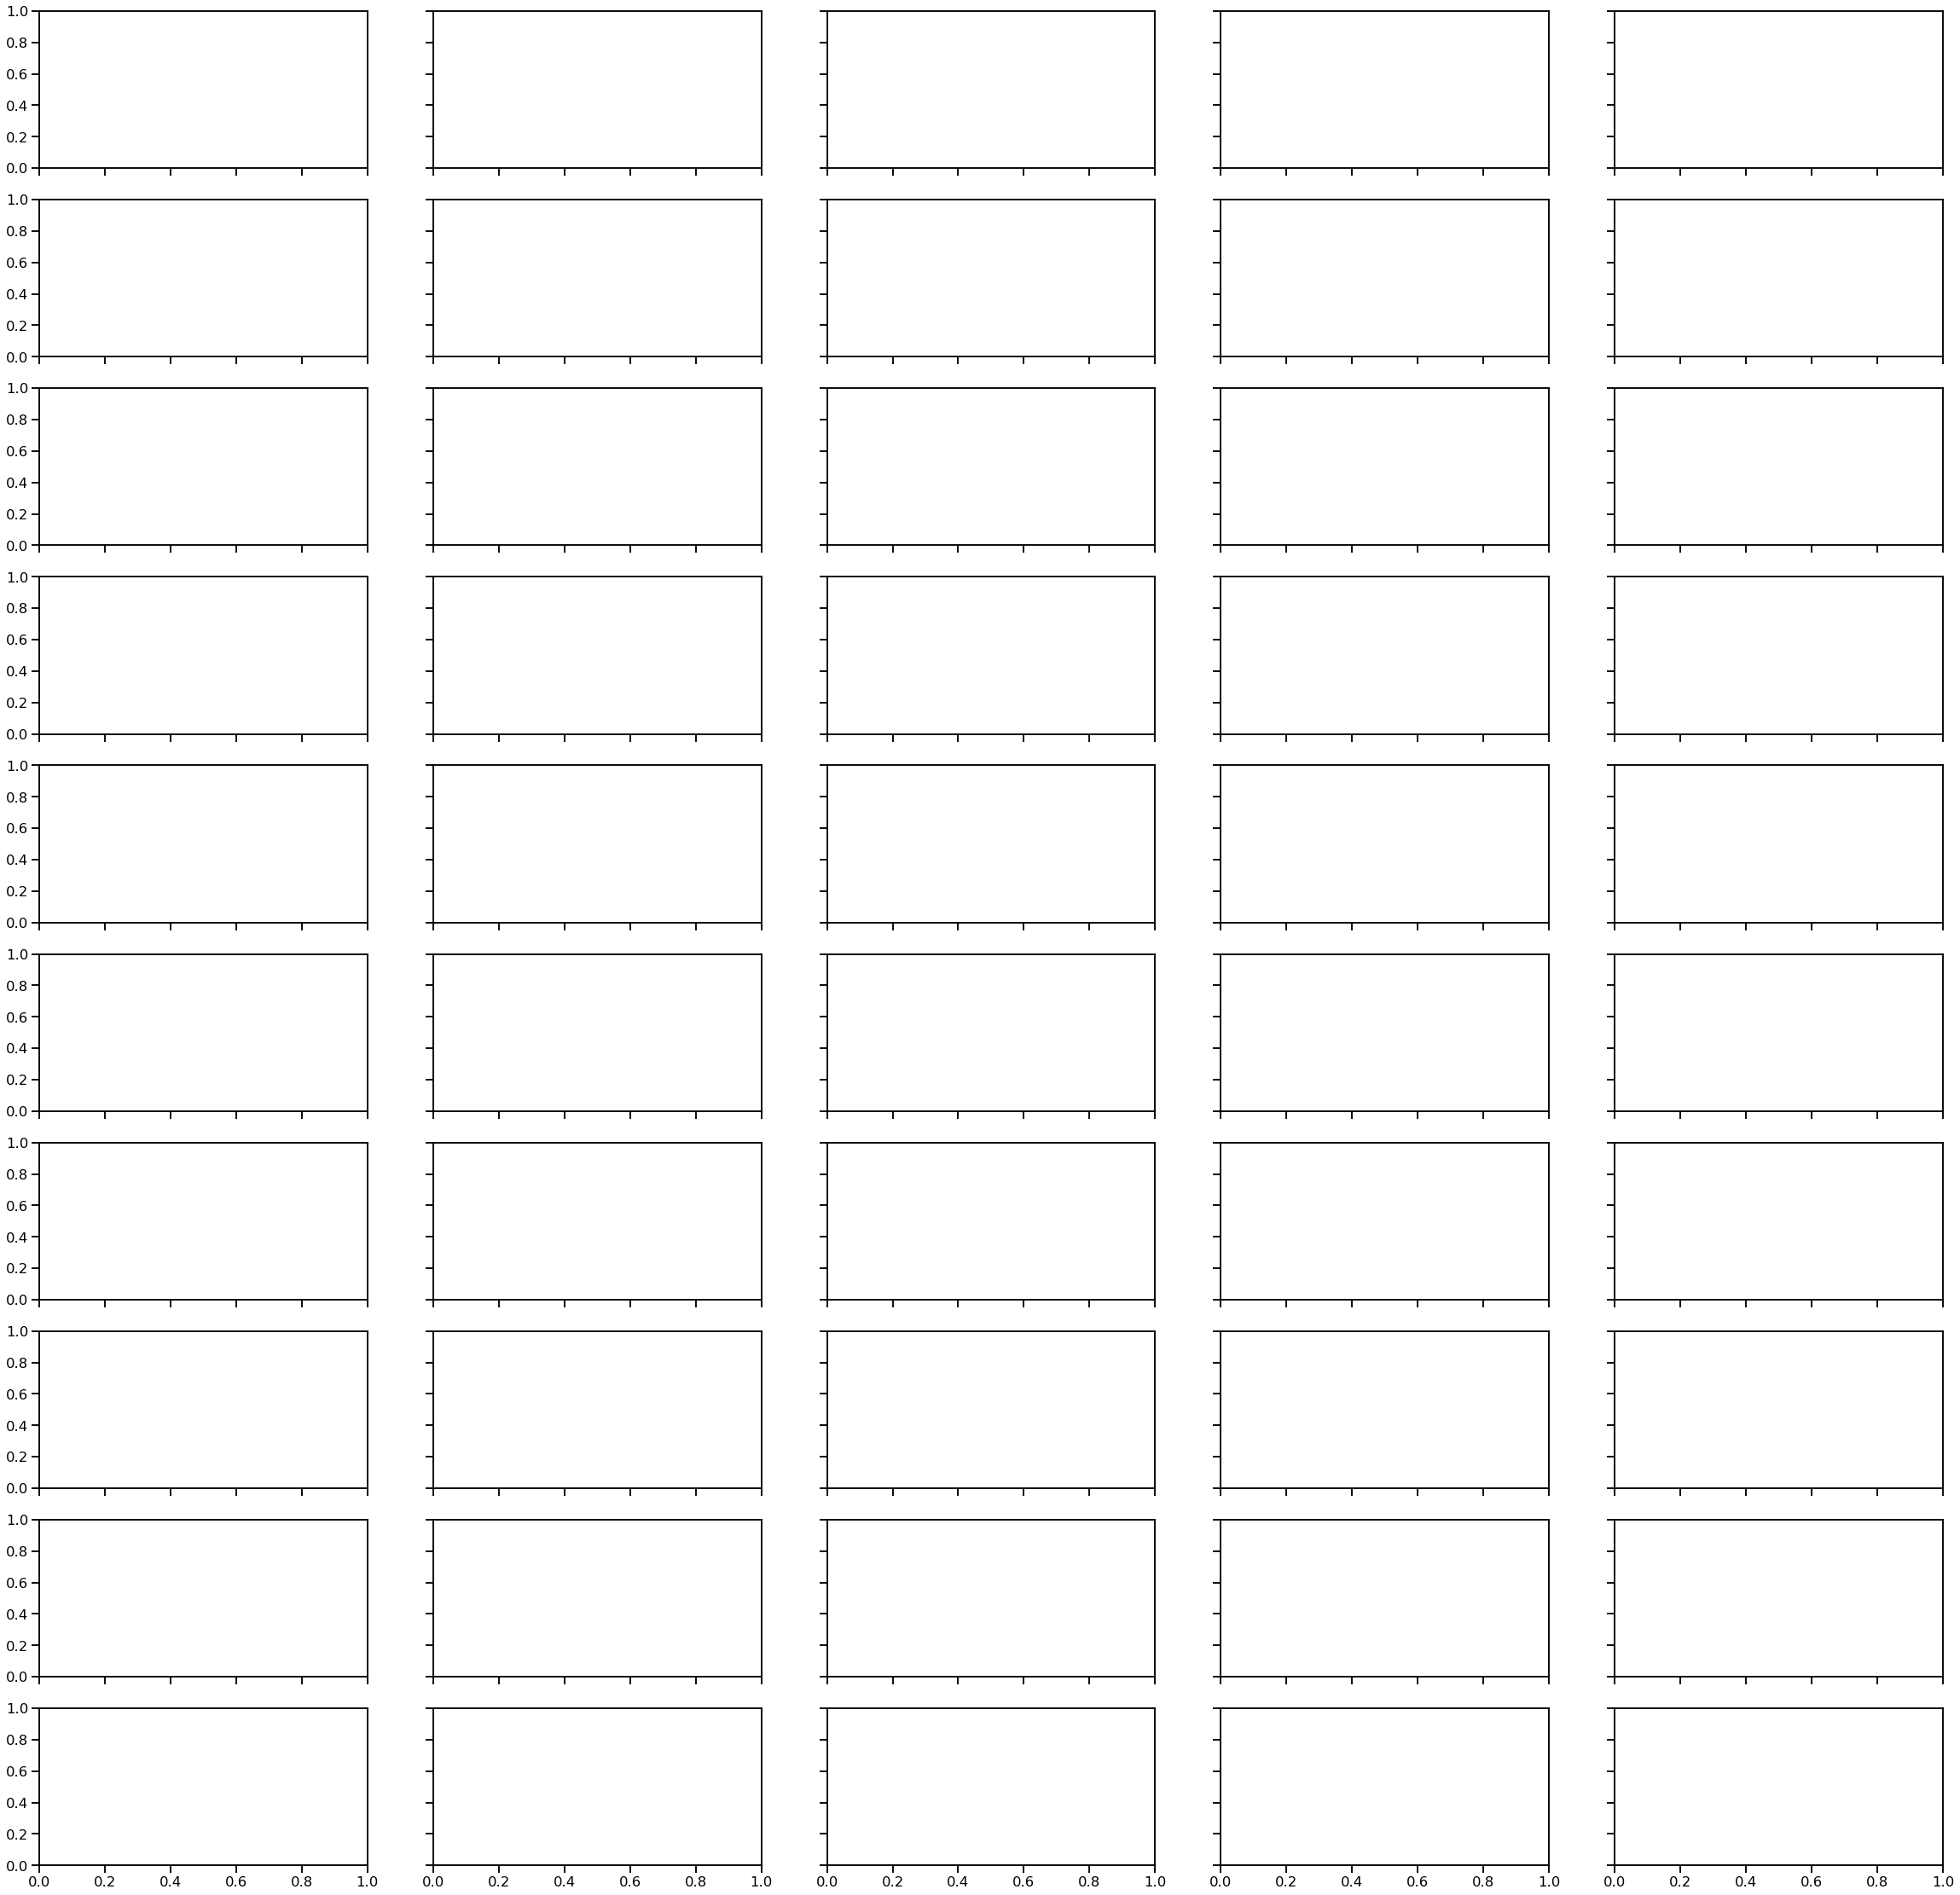

In [18]:
def plt_all_together(sub_df,ax):
  metric_fn_L = [
    mov_avg_subdf,
    winstay_war,
    respond_same_node_counting_subdf,
    respond_same_button_subdf
  ]
  labelL = [
    'acc','winstay','samendoe','samebutton'
  ]
  for ix,metric_fn in enumerate(metric_fn_L):
    metric_val = metric_fn(sub_df)
    ax.plot(metric_val,label=labelL[ix])
    
plt_wrap(plt_all_together)
if SAVING:
  plt_name='all_together'
  plt.savefig('figures/windowed_analyses/%s-%s'%(plt_name,CONDITION))